In [65]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans ,DBSCAN ,AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [66]:
df=pd.read_csv("/home/intellect/Documents/Unsupervised_Capstone/13_customer_segmentation.csv")
print("First few rows:\n",df.head())

First few rows:
   customer_id  age  income  spending_score  visits_per_month
0    CUST1000   56  120186              55                 9
1    CUST1001   69   49674              80                 1
2    CUST1002   46   61271              62                 8
3    CUST1003   32   88688              30                 6
4    CUST1004   60  126076              55                 6


In [67]:
print("Performing Statistical Function:\n",df.describe())

Performing Statistical Function:
               age         income  spending_score  visits_per_month
count  1000.00000    1000.000000     1000.000000       1000.000000
mean     43.81900   83958.460000       48.681000         10.087000
std      14.99103   39293.028951       29.082659          5.543299
min      18.00000   15126.000000        1.000000          1.000000
25%      31.00000   50012.250000       22.000000          5.000000
50%      44.00000   84322.000000       48.000000         10.000000
75%      56.00000  118153.000000       74.000000         15.000000
max      69.00000  149869.000000       99.000000         19.000000


In [68]:
print("Dataset Information:\n",df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       1000 non-null   object
 1   age               1000 non-null   int64 
 2   income            1000 non-null   int64 
 3   spending_score    1000 non-null   int64 
 4   visits_per_month  1000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB
Dataset Information:
 None


In [69]:
print("Checking Null Values:\n",df.isnull().sum())

Checking Null Values:
 customer_id         0
age                 0
income              0
spending_score      0
visits_per_month    0
dtype: int64


In [70]:
df.dropna(inplace=True)

In [71]:
x=df.drop("customer_id",axis=1)

In [72]:
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)

In [76]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

In [78]:
pca_df=pd.DataFrame(x_pca,columns=["PC1","PC2"])

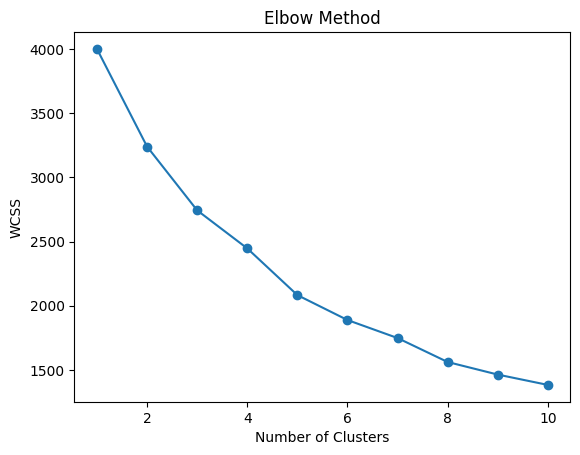

In [79]:
wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()


In [80]:
kmeans = KMeans(n_clusters=6, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(x_scaled)

In [85]:
silhouette_kmeans=silhouette_score(x_scaled,df['kmeans_cluster'])
silhouette_kmeans

0.20123907187142362

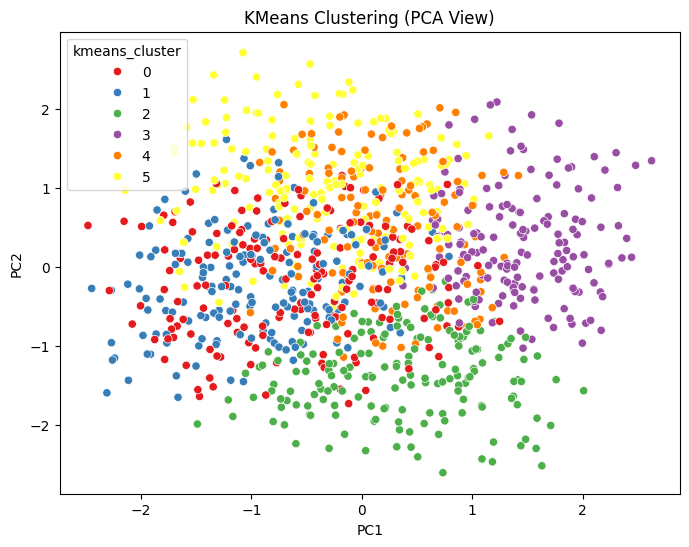

In [86]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_df["PC1"],y=pca_df["PC2"],hue=df['kmeans_cluster'],palette='Set1')
plt.title("KMeans Clustering (PCA View)")
plt.show()

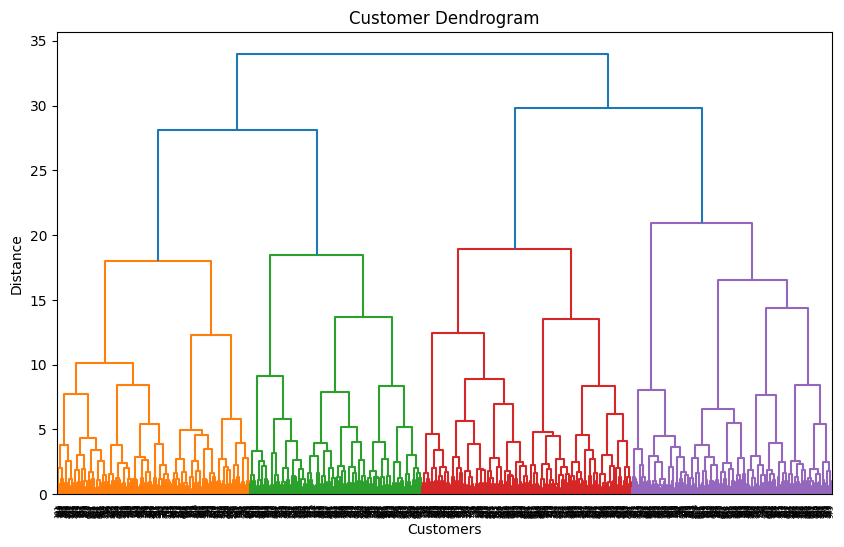

In [88]:
linked = linkage(x_scaled, method='ward')

plt.figure(figsize=(10,6))
dendrogram(linked)
plt.title("Customer Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()


In [89]:
hc=AgglomerativeClustering(n_clusters=4)
df['hierarchical_cluster']=hc.fit_predict(x_scaled)

In [91]:
silhouette_hc = silhouette_score(x_scaled, df['hierarchical_cluster'])
silhouette_hc

0.14757327979569923

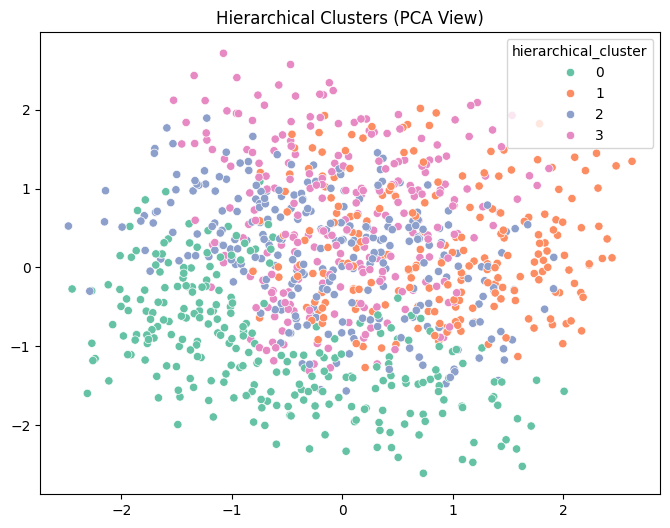

In [92]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1],
                hue=df['hierarchical_cluster'], palette='Set2')
plt.title("Hierarchical Clusters (PCA View)")
plt.show()


In [96]:
dbscan=DBSCAN(eps=0.8,min_samples=5)
df['dbscan_cluster']=dbscan.fit_predict(x_scaled)

df['dbscan_cluster'].value_counts()

dbscan_cluster
 0    998
-1      2
Name: count, dtype: int64

In [97]:
labels=df['dbscan_cluster']

if len(set(labels))> 1 and -1 not in set(labels):
    silhouette_dbscan=silhouette_score(x_scaled,labels)
else:
    silhouette_dbscan="Not Valid due to noise points"

silhouette_dbscan        

'Not Valid due to noise points'

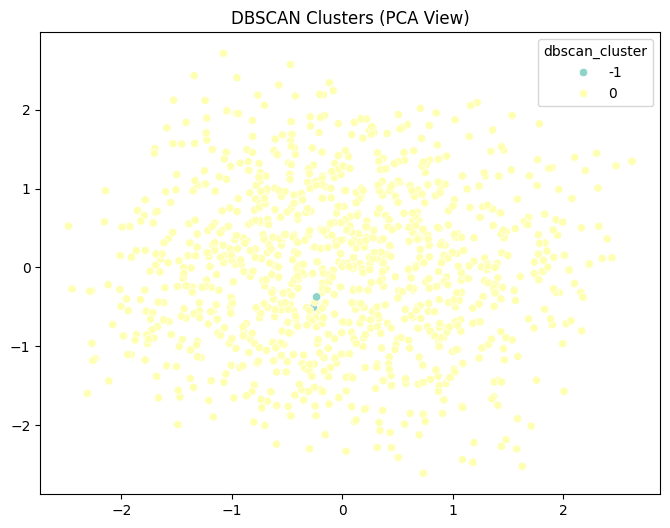

In [98]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=df['dbscan_cluster'], palette='Set3')
plt.title("DBSCAN Clusters (PCA View)")
plt.show()

In [99]:
results = pd.DataFrame({
    "Algorithm": ["KMeans", "Hierarchical", "DBSCAN"],
    "Silhouette Score": [silhouette_kmeans, silhouette_hc, silhouette_dbscan]
})

results


,Algorithm,Silhouette Score
0,KMeans,0.201239
1,Hierarchical,0.147573
2,DBSCAN,Not Valid due to noise points


In [100]:
df.groupby('kmeans_cluster')[['age','income','spending_score','visits_per_month']].mean()

,age,income,spending_score,visits_per_month
kmeans_cluster,,,,
0,59.017045,51092.193182,57.000000,12.659091
1,38.871345,66062.467836,22.964912,4.725146
2,55.569767,117758.953488,54.651163,5.104651
3,35.876543,120318.259259,74.592593,12.882716
4,30.117647,51060.580882,71.507353,9.330882
5,39.994536,92782.595628,19.196721,15.393443


In [101]:
import joblib
clustering_pipeline = {
    "scaler": scaler,
    "pca": pca,
    "kmeans": kmeans,
    "hierarchical": hc,
    "dbscan": dbscan
}
joblib.dump(clustering_pipeline, "intelligent_customer_segmentation.pkl")

print("Complete clustering system saved in one file!")


Complete clustering system saved in one file!
